In [12]:
from collections import defaultdict
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import numpy as np

def weightedCVT(pts, rho, num_iterations = 50):
    """Computes a weighted centroidal voronoi diagram of a set of points with a given 
    density function. 
    
    Args:
        pts: A set of initial voronoi point sites. 
        rho: A numpy array indexed by [x][y] for the density at point (x, y). Note
            that rho[x][y] can be 0 but should not be negative. If a region has all
            zero density it's centroid is calculated as the average of its neighbors.
        num_iterations: OPTIONAL Change the number of iterations of Lloyd's algorithm.
            Default is 50. 
    Returns:
        The final location of the sites as an N x 2 matrix where N is the number of input
        points. 
    """
    w, h = rho.shape
    
    diameter = max(w, h) * 1.414214
    
    # Compute the helper matrices used for fast computation of the 
    # CVT integrals (See [Secord 02])
    P = np.cumsum(rho, axis = 0)
    Q = np.cumsum(P, axis = 0)
    
    boundary_polygon = Polygon(np.array([[0,0],[w,0],[w,h],[0, h]]))

    current_sites = pts
    
    # Lloyd's algorithm 
    for _ in range(num_iterations):
        polys = list(voronoi_polygons(Voronoi(current_sites), diameter))
        polygons = [Polygon(p).intersection(boundary_polygon) for p in polys]
        centroids = []
        for p in polygons:
            c = wcvt_centroid(intCoords(list(p.exterior.coords)[:-1]), P, Q)
            centroids.append(c)
        current_sites = np.array(centroids)
    
    return current_sites

def worldToImgPixelCoords(world_x, 
                          world_y, 
                          img_x, 
                          img_y, 
                          img_w, 
                          img_h, 
                          img_pixels_w, 
                          img_pixels_h, 
                          truncate = True):
    """Converts a point in world coordinates to image pixel coordinates for an image with top left corner
    placed at (img_x, img_y) and dimensions img_w x img_h. 
    
    Args: 
        world_x: the x-coordinate of the point
        world_y: the y-coordinate of the point
        img_x: the x-coordinate of the top left hand corner of the image
        img_y: the y-coordinate of the top left hand corner of the image
        img_w: the width in world coordinates of the image
        img_h: the height in world coordinates of the image
        img_pixels_w: the number of pixels along the width of the image
        img_pixels_h: the number of pixels along the height of the image
        truncate: (Optional) if True does not return pixel values outside the image for world coordinates 
            outside the image, but instead projects onto the image boundary
    Returns:
        (x, y) in pixel coordinates where the left 
    """
    x = (world_x - img_x) * img_pixels_w / img_w
    y = (img_y - world_y) * img_pixels_w / img_w
    if truncate: 
        x = min(max(0, x), img_pixels_w)
        y = min(max(0, y), img_pixels_h)
    return (int(x), int(y))

def imgPixelToWorldCoords(pixel_x, pixel_y, img_x, img_y, img_w, img_h, img_pixels_w, img_pixels_h):
    """Converts a pixel coordinate to world coordinates.
    
    Args:
        pixel_x: the x-coordinate in pixels in the image
        pixel_y: the y-coordinate in pixels in the image (larger is lower on screen)
        img_x: the x-coordinate of the top left hand corner of the image
        img_y: the y-coordinate of the top left hand corner of the image
        img_w: the width in world coordinates of the image
        img_h: the height in world coordinates of the image
        img_pixels_w: the number of pixels along the width of the image
        img_pixels_h: the number of pixels along the height of the image
    Returns:
        (x, y) in world coordinates for the bottom left hand corner of the pixel
    """
    x = pixel_x * img_w / img_pixels_w + img_x
    y = img_y - pixel_y * img_h / img_pixels_h
    return (x, y)

def rasterizeSegment(start_x, start_y, end_x, end_y):
    """Implementation of Bresenham's line rasterization routine. 
    This is a slightly modified version of the Python implementation
    one Rosetta code: https://rosettacode.org/wiki/Bitmap/Bresenham%27s_line_algorithm#Python
    
    Args: 
        start_x: the x-coordinate of the start point of the segment
        start_y: the y-coordinate of the start point of the segment
        end_x: the x-coordinate of the end point of the segment
        end_y: the y-coordinate of the end point of the segment
    Returns: 
        A list [(x, y)] of the image pixel coordinates along the line
    """
    result = []
    dx = abs(end_x - start_x)
    dy = abs(end_y - start_y)
    x, y = start_x, start_y
    sx = -1 if start_x > end_x else 1
    sy = -1 if start_y > end_y else 1
    if dx > dy:
        err = dx / 2.0
        while x != end_x:
            result.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else: 
        err = dy / 2.0
        while y != end_y:
            result.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    result.append((x, y))
    return result

def rasterizePolygon(pts):
    """Takes a polygon as a list of coordinates and rasterizes onto an integer grid.
    
    Args:
        pts: List[(int, int)]. A list of 2D integer coordinates of the vertices of the 
            polygon. Note that the polygon is assumed closed, so the segment between the 
            last point in pts and first point in pts is also added. 
    Returns:
        The pixel coordinates of the boundary of the polygon. 
    """
    result = []
    n = len(pts)
    for i in range(n):
        result += rasterizeSegment(*pts[i], *pts[(i+1)%n])
    return result

def scanPoints(pts):
    """Returns the x-coordinate extremes across each y coordinate of a convex polygon. 
    This is used in evaluating the bounds of the integral for the weighted CVT
    computation.
    
    Args:
        pts: List[(int, int)]. A list of 2D integer coordinates of the vertices of the 
            polygon. Note that the polygon is assumed closed, so the segment between the 
            last point in pts and first point in pts is also added. Assumed to be in 
            convex position. 
    Returns:
        A list containing the two points of intersection (x1, y), (x2, y) with x1 < x2
        for each integer y horizontal crossed by the polygon. The list is returned in 
        lexigraphical order sorted by y-coordinate first and x-coordinate second. 
    """
    spts = sorted(set(rasterizePolygon(pts)), key=lambda t: (t[1], t[0]))
    result = []
    n = len(spts)
    for i in range(n):
        if ((spts[i-1][1] != spts[i][1] and spts[i][1] == spts[(i+1)%n][1])
            or (spts[i-1][1] == spts[i][1] and spts[i][1] != spts[(i+1)%n][1])):
            result.append(spts[i])
    return result

def trunc(x, y, w, h):
    """Truncates x and y coordinates to live in the (0, 0) to (w, h)
    
    Args: 
        x: the x-coordinate of a point
        y: the y-coordinate of a point
        w: the width of the truncation box
        h: the height of the truncation box. 
    """
    return min(max(x, 0), w - 1), min(max(y, 0), h - 1)

def wcvt_denominator(spts, P):
    """The denominator of the centroidal voronoi diagram centroid computation. 
    
    Args:
        spts: The scan points (see scanPoints()) for the region. 
        P: The pre-computed partial integral from [Secord 02]
    
    Returns:
        The denominator of the integral. 
    """
    result_sum = 0
    w, h = P.shape
    for i in range(0, len(spts), 2):
        x1, y = trunc(*spts[i], w, h)
        x2, _ = trunc(*spts[i+1], w, h)
        result_sum += (P[x2][y] - P[x1][y])
    return result_sum

def wcvt_ynumerator(spts, P):
    """The numerator for the y-coordinate of the centroidal voronoi diagram 
    centroid computation. 
    
    Args:
        spts: The scan points (see scanPoints()) for the region. 
        P: The pre-computed partial integral from [Secord 02] (Note it is simply the 
            cumulative sum of rho across the x axis.)
    
    Returns:
        The y-coordinate numerator of the integral. 
    """
    result_sum = 0
    w, h = P.shape
    for i in range(0, len(spts), 2):
        x1, y = trunc(*spts[i], w, h)
        x2, _ = trunc(*spts[i+1], w, h)
        result_sum += (y * (P[x2][y] - P[x1][y]))
    return result_sum

def wcvt_xnumerator(spts, P, Q):
    """The numerator for the x-coordinate of the centroidal voronoi diagram 
    centroid computation. 
    
    Args:
        spts: The scan points (see scanPoints()) for the region. 
        P: The pre-computed partial integral from [Secord 02] (Note it is simply the 
            cumulative sum of rho across the x axis.)
        Q: The second pre-computed partial integral from [Secord 02] (Note it is simply the 
            cumulative sum of P across the x axis.)
    
    Returns:
        The x-coordinate numerator of the integral. 
    """
    result_sum = 0
    w, h = P.shape
    for i in range(0, len(spts), 2):
        x1, y = trunc(*spts[i], w, h)
        x2, _ = trunc(*spts[i+1], w, h)
        result_sum += ((x2 * P[x2][y] - Q[x2][y]) - (x1 * P[x1][y] - Q[x1][y]))
    return result_sum

def avg_point(pts):
    """The average of a list of points.
    
    Args:
        pts: List[(number, number)] A list of points.
    
    Returns:
        The average point.
    """
    sumx, sumy = 0, 0
    invlen = 1 / len(pts)
    for x, y in pts:
        sumx += x
        sumy += y
    return (sumx * invlen, sumy * invlen)
    
def wcvt_centroid(pts, P, Q):
    """Computes the Voronoi centroid of the Voronoi region with corners given by the 
    polygon pts (without repetition of the last vertex).
    
    Args:
        pts: List[(int, int)] of points given in integer coordinates with no repeated end vertex. 
        P: The pre-computed partial integral from [Secord 02] (Note it is simply the 
            cumulative sum of rho across the x axis.)
        Q: The second pre-computed partial integral from [Secord 02] (Note it is simply the 
            cumulative sum of P across the x axis.)
    
    Returns: 
        The weighted centroid of the Voronoi region.
    """
    spts = scanPoints(pts)
    denom = wcvt_denominator(spts, P)
    if denom == 0:
        return avg_point(pts)
    else: 
        inv_denom = 1 / denom
        return (wcvt_xnumerator(spts, P, Q) * inv_denom, 
                wcvt_ynumerator(spts, P) * inv_denom)

def voronoi_polygons(voronoi, diameter):
    """Generate shapely.geometry.Polygon objects corresponding to the
    regions of a scipy.spatial.Voronoi object, in the order of the
    input points. The polygons for the infinite regions are large
    enough that all points within a distance 'diameter' of a Voronoi
    vertex are contained in one of the infinite polygons.
    
    Author: From Gareth Rees's solution at 
        https://stackoverflow.com/questions/23901943/voronoi-compute-exact-boundaries-of-every-region
    """
    centroid = voronoi.points.mean(axis=0)

    # Mapping from (input point index, Voronoi point index) to list of
    # unit vectors in the directions of the infinite ridges starting
    # at the Voronoi point and neighbouring the input point.
    ridge_direction = defaultdict(list)
    for (p, q), rv in zip(voronoi.ridge_points, voronoi.ridge_vertices):
        u, v = sorted(rv)
        if u == -1:
            # Infinite ridge starting at ridge point with index v,
            # equidistant from input points with indexes p and q.
            t = voronoi.points[q] - voronoi.points[p] # tangent
            n = np.array([-t[1], t[0]]) / np.linalg.norm(t) # normal
            midpoint = voronoi.points[[p, q]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - centroid, n)) * n
            ridge_direction[p, v].append(direction)
            ridge_direction[q, v].append(direction)

    for i, r in enumerate(voronoi.point_region):
        region = voronoi.regions[r]
        if -1 not in region:
            # Finite region.
            yield voronoi.vertices[region]
            continue
        # Infinite region.
        inf = region.index(-1)              # Index of vertex at infinity.
        j = region[(inf - 1) % len(region)] # Index of previous vertex.
        k = region[(inf + 1) % len(region)] # Index of next vertex.
        if j == k:
            # Region has one Voronoi vertex with two ridges.
            dir_j, dir_k = ridge_direction[i, j]
        else:
            # Region has two Voronoi vertices, each with one ridge.
            dir_j, = ridge_direction[i, j]
            dir_k, = ridge_direction[i, k]

        # Length of ridges needed for the extra edge to lie at least
        # 'diameter' away from all Voronoi vertices.
        length = 2 * diameter / np.linalg.norm(dir_j + dir_k)

        # Polygon consists of finite part plus an extra edge.
        finite_part = voronoi.vertices[region[inf + 1:] + region[:inf]]
        extra_edge = [voronoi.vertices[j] + dir_j * length,
                      voronoi.vertices[k] + dir_k * length]
        yield np.concatenate((finite_part, extra_edge))

def intCoords(coords):
    """Convenience for converting a list of coordinates into integer coordinates.
    
    Args:
        coords: List[(float, float)]
    
    Returns:
        List[(int, int)]
    """
    return [(int(x), int(y)) for x, y in coords]

In [13]:
im.show()

In [4]:
from PIL import Image
import random

im = Image.open("data/cauchy.jpg")
w, h = im.size
im = im.resize((5*w, 5*h), Image.ANTIALIAS)
w, h = im.size

I = np.array(im)
rho = np.array(im).astype(float).T

for i in range(w):
    for j in range(h):
        rho[i][j] = (256 - rho[i][j]) / 256

sites = np.array([
    [int(random.random() * w), int(random.random() * h)]
    for _ in range(1000)
])

cvt_sites = weightedCVT(sites, rho)

In [5]:
from PIL import Image
import numpy as np

im = Image.open("data/cauchy.jpg")
w, h = im.size
im = im.resize((5*w, 5*h), Image.ANTIALIAS)
w, h = im.size
print(w,h)
I = np.array(im)

rho = np.array(im).astype(float)

for i in range(h):
    for j in range(w):
        rho[i][j] = (256 - rho[i][j]) / 256
        #rho[i][j] = rho[i][j] * rho[i][j]
        
P = np.cumsum(rho, axis = 1)
Q = np.cumsum(P, axis = 1)

rho = rho.transpose()
P = P.transpose()
Q = Q.transpose()

for i in range(h):
    for j in range(w):
        I[i][j] = 0

print(wcvt_xnumerator(spts, P, Q))
print(wcvt_ynumerator(spts, P))
print(wcvt_denominator(spts, P))
print(wcvt_centroid(pts, P, Q)) 

centroid = wcvt_centroid(pts, P, Q)

for x, y in [trunc(x0, y0, w, h)  for x0, y0 in rpts]:
    I[y][x] = 255

I[int(centroid[1])][int(centroid[0])] = 255
newIm = Image.fromarray(np.uint8(I))
newIm.show()

1000 1385


NameError: name 'spts' is not defined

In [6]:
import random
#sites = np.array([[52, 40.2], [156, 71.5], [47, 164.3], [140, 132.4], [109, 244.5]])
boundary_polygon = Polygon(np.array([[0,0],[w,0],[w,h],[0, h]]))

sites = np.array([
    [int(random.random() * w), int(random.random() * h)]
    for _ in range(1000)
])
diameter = 1000

In [7]:
# Show initial samples: 
for i in range(h):
    for j in range(w):
        I[i][j] = 0
for x, y in sites:
    I[int(y)][int(x)] = 255
newIm = Image.fromarray(np.uint8(I))
newIm.show()
im.show()

In [8]:
# Lloyd's algorithm: 
current_sites = sites
for _ in range(50):
    polys = list(voronoi_polygons(Voronoi(current_sites), diameter))
    polygons = [Polygon(p).intersection(boundary_polygon) for p in polys]
    centroids = []
    for p in polygons:
        c = wcvt_centroid(intCoords(list(p.exterior.coords)[:-1]), P, Q)
        centroids.append(c)
    current_sites = np.array(centroids)

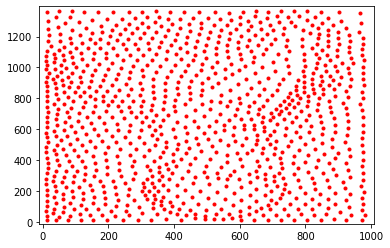

In [11]:
import matplotlib.pyplot as plt

plt.xlim(-10, w+10)
plt.ylim(-10, h+10)

#plt.plot(*sites.T, 'b.')

# for p in polygons:
#     x, y = zip(*list(p.exterior.coords))
#     plt.plot(x, y, 'r-')
    
plt.plot(*cvt_sites.T, 'r.')

plt.show()

In [10]:
for i in range(h):
    for j in range(w):
        I[i][j] = 0
for x, y in current_sites:
    I[int(y)][int(x)] = 255
newIm = Image.fromarray(np.uint8(I))
newIm.show()
im.show()

In [125]:
current_sites.shape

(1000, 2)

In [116]:
w, h

(1000, 1385)

In [117]:
rho.shape

(1000, 1385)

In [118]:
rhoT = rho.T


In [123]:
np.cumsum(rhoT, axis = 0)==np.cumsum(rho, axis = 1).T

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

array([[1.21093750e-01, 1.21093750e-01, 1.21093750e-01, ...,
        1.36718750e-01, 1.36718750e-01, 1.36718750e-01],
       [2.42187500e-01, 2.42187500e-01, 2.42187500e-01, ...,
        2.73437500e-01, 2.73437500e-01, 2.73437500e-01],
       [3.63281250e-01, 3.63281250e-01, 3.63281250e-01, ...,
        4.10156250e-01, 4.10156250e-01, 4.10156250e-01],
       ...,
       [3.17433594e+02, 3.18210938e+02, 3.18972656e+02, ...,
        3.19574219e+02, 3.18617188e+02, 3.17640625e+02],
       [3.17578125e+02, 3.18355469e+02, 3.19117188e+02, ...,
        3.19691406e+02, 3.18734375e+02, 3.17757812e+02],
       [3.17722656e+02, 3.18500000e+02, 3.19261719e+02, ...,
        3.19812500e+02, 3.18855469e+02, 3.17878906e+02]])